In [ ]:
######################################################################################################
#   Build  Supervised learning  ML model, where company needs to rollout promotional offers 
#   to few of its customers that is considered 
#   to potential high revenue customers for it business.
#   DataSet Used: Dummy DataSet - High Revenue Customers with the sample of 10000 Customer Details
######################################################################################################

In [2]:
##### Importing Relevant Libraries ######
#########################################


import pandas as pd
import numpy as np
import os
import seaborn as sns
import pickle ### helps storing data in pickle files

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix,f1_score ## model evaluation metrics
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler ## (x-mean(variable))/standard_deviation(variable)
from sklearn.model_selection import StratifiedShuffleSplit ### datasplitting
 
from sklearn.model_selection import GridSearchCV          ### hyperparameter finding

from sklearn.tree import DecisionTreeClassifier           ### helps fitting a decision tree


In [3]:
%matplotlib inline

In [4]:
def capping(series,quantile_val):
  cap_value = series.quantile(quantile_val)
  series[series>cap_value] = cap_value
  return(series, cap_value)

def get_percentages(col_1, col_2, data):
  x = pd.crosstab(data[col_1],data[col_2])
  return(x[1]/(x[1]+x[2]))

In [5]:
####### Loading Data ######
###########################

cwd = os.getcwd() ##gets current working directory

data_path = str(cwd) + '/Existing_Base.csv'

data = pd.read_csv(data_path)  ## Loads the data

# Data Exploration

In [6]:
data.shape ## gets the shape of the data

(10155, 32)

In [7]:
#### Distribution of target class ####

data['Revenue Grid'].value_counts()

#### There is class imbalance in my dataset. We might ask for more observations for class 1.

#### if the distribution is 80%-20% - generally not a major concern.
#### if the distribution is between 80%-20% and 95%-5% -  area of slight concern..
#### if the distribution is less than 95-5% - we should get concerned - expect that your model might be a bad modeldata['Revenue Grid'].value_counts() ##### There is class imbalance in my data #### We will have to do something to reduce the imbalance

2    9069
1    1086
Name: Revenue Grid, dtype: int64

In [ ]:
data.head()

,REF_NO,children,age_band,status,occupation,occupation_partner,home_status,family_income,self_employed,self_employed_partner,...,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Revenue Grid,gender,region,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance
0,1,Zero,51-55,Partner,Manual Worker,Secretarial/Admin,Own Home,"<17,500, >=15,000",No,No,...,19.99,0.00,0.00,1,Female,Wales,74.67,18.66,32.32,89.43
1,2,Zero,55-60,Single/Never Married,Retired,Retired,Own Home,"<27,500, >=25,000",No,No,...,0.00,0.00,0.00,2,Female,North West,20.19,0.00,4.33,22.78
2,3,Zero,26-30,Single/Never Married,Professional,Other,Own Home,"<30,000, >=27,500",Yes,No,...,0.00,3.49,0.00,2,Male,North,98.06,31.07,80.96,171.78
3,5,Zero,18-21,Single/Never Married,Professional,Manual Worker,Own Home,"<15,000, >=12,500",No,No,...,0.00,0.00,0.00,2,Female,West Midlands,4.10,14.15,17.57,-41.70
4,6,Zero,45-50,Partner,Business Manager,Unknown,Own Home,"<30,000, >=27,500",No,No,...,0.00,45.91,25.98,2,Female,Scotland,70.16,55.86,80.44,235.02


In [8]:
data.info() ### prints out informatio regarding columns in the data

#### Insight #####
####################

# Out of 32 columns, we have around 18 columns of numeric type, 14 columns of string type
# There doesn't seem to have missing values in the columns, however we would investigate this once again

####### Insights ########

# Ref number can be dropped
# Remove the - and convert age_band into numeric... if there are not too many unique age_bands we may even create dummies.
# Remove the >< and convert the family_income into a numeric column.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10155 entries, 0 to 10154
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   REF_NO                           10155 non-null  int64  
 1   children                         10155 non-null  object 
 2   age_band                         10155 non-null  object 
 3   status                           10155 non-null  object 
 4   occupation                       10155 non-null  object 
 5   occupation_partner               10155 non-null  object 
 6   home_status                      10155 non-null  object 
 7   family_income                    10155 non-null  object 
 8   self_employed                    10155 non-null  object 
 9   self_employed_partner            10155 non-null  object 
 10  year_last_moved                  10155 non-null  int64  
 11  TVarea                           10155 non-null  object 
 12  post_code         

In [ ]:
######## Insights ############

### Ref number can be removed
### Age_band is an object column due to '-'. Remove - and take average of the age band and convert to numeric

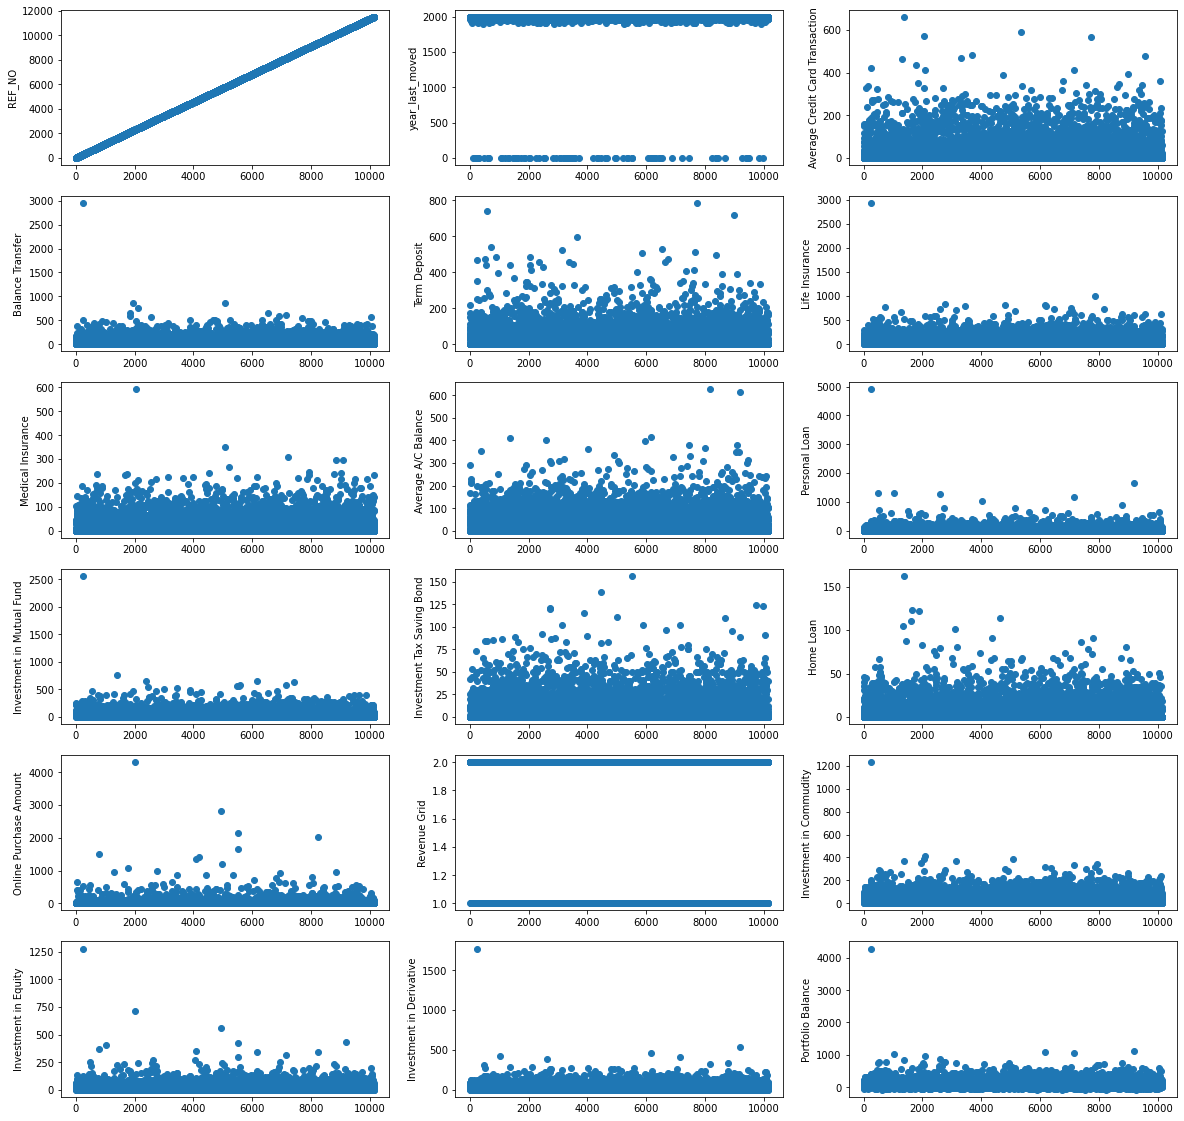

In [9]:
#### Visualizing numeric columns ######

numeric_cols = data.select_dtypes(include = np.number) ### selects numeric columns

column_names = list(numeric_cols.columns)

col_index = 0

plot_rows = 6
plot_cols = 3

fig, ax = plt.subplots(nrows = plot_rows,ncols=plot_cols,figsize = (20,20))

for row_count in range(plot_rows):
    for col_count in range(plot_cols):
        ax[row_count][col_count].scatter(y = numeric_cols[column_names[col_index]],x=numeric_cols.index)
        ax[row_count][col_count].set_ylabel(column_names[col_index])
        col_index = col_index + 1
        
###### Insights #####
#####################

## Ref Number column just contains the index so can be removed.
## year_last_moved column seem to have many values close to 0 or 0, these seem to be noise, investigate them.
## Average_credit_card_transaction,Balance Transfer seems to be highly right skewed, check if the skewness could be reduced. ###Later
## A single customer with very high value of balance transfer/life insurance etc stands out, this row could be considered outlier and be removed, #row number 250
## Capping could be done to limit the impact of outliers.
## Scaling could be done since the scale is different for most of the variables. ## Incorrect

In [10]:
data.loc[data['Life Insurance']>2500,:]['Investment in Commudity']

250    1231.09
Name: Investment in Commudity, dtype: float64

C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Investment in Commudity', ylabel='Density'>

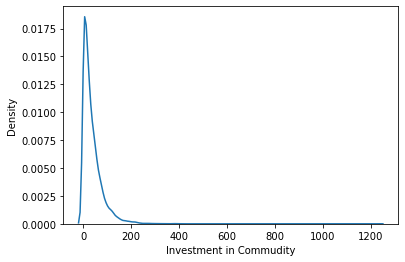

In [11]:
sns.distplot(data['Investment in Commudity'],hist = False)

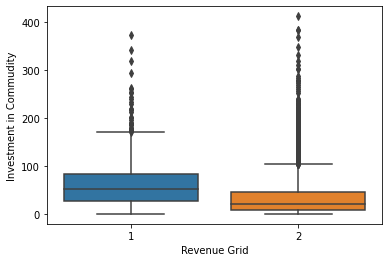

In [ ]:
sns.boxplot(x = data.loc[data['Investment in Commudity']<1000, 'Revenue Grid'], y = data.loc[data['Investment in Commudity']<1000, 'Investment in Commudity'])

C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Investment Tax Saving Bond', ylabel='Density'>

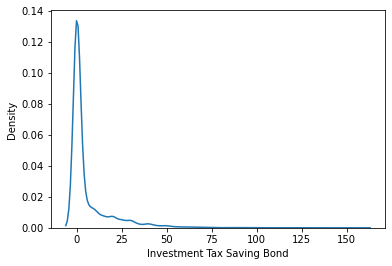

In [12]:
sns.distplot((data['Investment Tax Saving Bond']),hist = False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


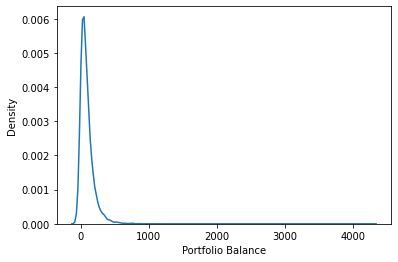

In [ ]:
sns.distplot(data['Portfolio Balance'],hist = False)

C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Investment in Equity', ylabel='Density'>

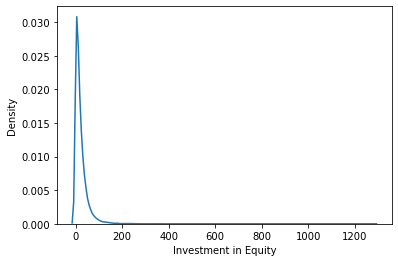

In [13]:
sns.distplot(data['Investment in Equity'],hist = False)

In [15]:
data.groupby(['Revenue Grid']).agg({'Online Purchase Amount': ['mean', 'median']})

Online Purchase Amount        
                               mean  median
Revenue Grid                               
1                        118.808066  55.845
2                          7.230388   0.000

<AxesSubplot:xlabel='Revenue Grid', ylabel='Online Purchase Amount'>

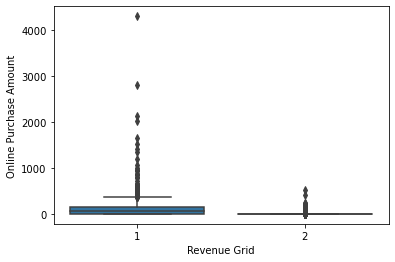

In [14]:
sns.boxplot(x='Revenue Grid', y = 'Online Purchase Amount', data = data)

In [16]:
np.sum(data['year_last_moved']==0) #### This computes the number of 0's in the year last moved columns

84

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


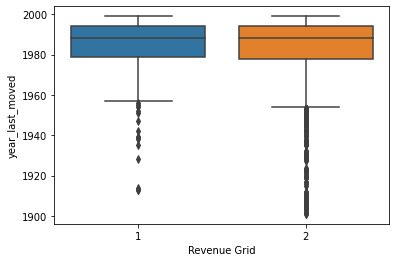

In [ ]:
sns.boxplot(data.loc[data['year_last_moved']>0,'Revenue Grid'], data.loc[data['year_last_moved']>0,'year_last_moved'])

In [17]:
##### Desired state : we want features with low correlation amongst themselves and high correlation with the target columns

data[column_names].corr()

,REF_NO,year_last_moved,Average Credit Card Transaction,Balance Transfer,Term Deposit,Life Insurance,Medical Insurance,Average A/C Balance,Personal Loan,Investment in Mutual Fund,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Revenue Grid,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance
REF_NO,1.000000,0.028739,-0.001217,-0.010711,-0.002313,0.008301,0.020776,-0.005197,-0.010802,-0.006030,0.000775,-0.014010,0.003267,-0.010578,0.002082,-0.007154,-0.000234,-0.000721
year_last_moved,0.028739,1.000000,0.014296,0.013535,0.004404,0.010689,0.015484,0.003031,0.019718,0.002569,0.013158,0.003282,-0.005826,-0.018655,0.016802,0.008586,0.015582,0.017298
Average Credit Card Transaction,-0.001217,0.014296,1.000000,0.123855,0.323462,0.145041,0.405090,0.172240,0.087289,0.150667,0.133126,0.087695,0.132518,-0.265197,0.497025,0.205289,0.228141,0.335674
Balance Transfer,-0.010711,0.013535,0.123855,1.000000,0.229457,0.564538,0.162085,0.358938,0.351499,0.454602,0.166496,0.153097,0.112012,-0.074756,0.739791,0.463556,0.581039,0.639400
Term Deposit,-0.002313,0.004404,0.323462,0.229457,1.000000,0.274691,0.506367,0.274027,0.146755,0.208948,0.176975,0.170584,0.099455,-0.011817,0.620256,0.266908,0.354304,0.454740
Life Insurance,0.008301,0.010689,0.145041,0.564538,0.274691,1.000000,0.238435,0.514339,0.380563,0.544439,0.263675,0.279959,0.128785,-0.216090,0.803326,0.564287,0.839266,0.787311
Medical Insurance,0.020776,0.015484,0.405090,0.162085,0.506367,0.238435,1.000000,0.264615,0.105134,0.209651,0.201057,0.136310,0.149651,-0.092966,0.548282,0.269922,0.392548,0.441631
Average A/C Balance,-0.005197,0.003031,0.172240,0.358938,0.274027,0.514339,0.264615,1.000000,0.219801,0.448270,0.307552,0.367590,0.162821,-0.112118,0.517832,0.600278,0.657742,0.616051
Personal Loan,-0.010802,0.019718,0.087289,0.351499,0.146755,0.380563,0.105134,0.219801,1.000000,0.379615,0.233020,0.128062,0.073292,0.028982,0.377170,0.676053,0.687417,0.598919
Investment in Mutual Fund,-0.006030,0.002569,0.150667,0.454602,0.208948,0.544439,0.209651,0.448270,0.379615,1.000000,0.271580,0.261562,0.115087,-0.114689,0.536715,0.693435,0.761125,0.695337


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10155 entries, 0 to 10154
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   REF_NO                           10155 non-null  int64  
 1   children                         10155 non-null  object 
 2   age_band                         10155 non-null  object 
 3   status                           10155 non-null  object 
 4   occupation                       10155 non-null  object 
 5   occupation_partner               10155 non-null  object 
 6   home_status                      10155 non-null  object 
 7   family_income                    10155 non-null  object 
 8   self_employed                    10155 non-null  object 
 9   self_employed_partner            10155 non-null  object 
 10  year_last_moved                  10155 non-null  int64  
 11  TVarea                           10155 non-null  object 
 12  post_code         

In [18]:
##### Describing categorical columns #####

cat_data = data.select_dtypes(include = np.object) ##subsets the object columns

column_names = list(cat_data.columns) ### column names of the object columns

for column in column_names:
    print('Column ', column)
    print('Number of unique elements ', cat_data[column].nunique())
    print('***************\n')
    
##### Insights ######
#####################

## post_code has too many unique values, converting them into onehot encoded vectors would blow up the dimensions. Currently we will remove the column and go ahead with the model
## Similarly for post area

Column  children
Number of unique elements  5
***************

Column  age_band
Number of unique elements  13
***************

Column  status
Number of unique elements  5
***************

Column  occupation
Number of unique elements  9
***************

Column  occupation_partner
Number of unique elements  9
***************

Column  home_status
Number of unique elements  5
***************

Column  family_income
Number of unique elements  13
***************

Column  self_employed
Number of unique elements  2
***************

Column  self_employed_partner
Number of unique elements  2
***************

Column  TVarea
Number of unique elements  14
***************

Column  post_code
Number of unique elements  10040
***************

Column  post_area
Number of unique elements  2039
***************

Column  gender
Number of unique elements  3
***************

Column  region
Number of unique elements  13
***************



C:\Users\ADMIN\AppData\Local\Temp\ipykernel_632\2596921976.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cat_data = data.select_dtypes(include = np.object) ##subsets the object columns


# Data Preprocessing

In [19]:
print('The shape of the data before preprocessing ', data.shape)

The shape of the data before preprocessing  (10155, 32)


In [ ]:
data = data.loc[data['Life Insurance']<2500,:] ### Dropping the customer with unusually high feature values

In [20]:
remove_cols = []

In [21]:
#### Preprocess - 1: Remove the Ref_no AND YEAR_LAST_Moved column ####
data.drop(['REF_NO'],axis=1,inplace=True)  ## removes specified columns
data.drop(['year_last_moved'],axis=1,inplace=True)
remove_cols.append('REF_NO')
remove_cols.append('year_last_moved')

In [22]:
data.shape

(10155, 30)

In [23]:
data.drop(['post_code','post_area'],axis=1,inplace=True)

remove_cols.extend(['post_code','post_area'])

In [24]:
print('The shape of the data after first preprocessing block ', data.shape)

data.reset_index(drop=True,inplace=True) ### resetting index

The shape of the data after first preprocessing block  (10155, 28)


In [25]:
######## Capping ###########

numeric_cols = data.select_dtypes(include = np.number) ### Data frame with only numeric columns
column_names = list(numeric_cols.columns)
column_names.remove('Revenue Grid')

data.loc[data['Medical Insurance']>=300, 'Medical Insurance'] = 300
data.loc[data['Average A/C Balance']>=400, 'Average A/C Balance'] = 400
data.loc[data['Online Purchase Amount']>=2000, 'Online Purchase Amount'] = 2000
data.loc[data['Investment in Equity']>=400, 'Investment in Equity'] = 400

In [26]:
column_names

['Average Credit Card Transaction',
 'Balance Transfer',
 'Term Deposit',
 'Life Insurance',
 'Medical Insurance',
 'Average A/C Balance',
 'Personal Loan',
 'Investment in Mutual Fund',
 'Investment Tax Saving Bond',
 'Home Loan',
 'Online Purchase Amount',
 'Investment in Commudity',
 'Investment in Equity',
 'Investment in Derivative',
 'Portfolio Balance']

In [27]:
###### Preprocess -4 : Capping the numeric columns to 99.95th percentile #####

numeric_cols = data.select_dtypes(include = np.number) ### Data frame with only numeric columns
column_names = list(numeric_cols.columns) ### contains the numeric column names
column_names.remove('Revenue Grid')  ### removing revenue grid

for column in column_names:  ### iterating over all numeric columns
    percentile_9995_val = np.quantile(data[column],0.9995)  ### finding the 99.95th percentile value
    print (column, percentile_9995_val)
    data.loc[data[column]>percentile_9995_val,column] = percentile_9995_val  ## replace all the values greater than 95th percentile with the 95th percentile value



Average Credit Card Transaction 477.05462000000676
Balance Transfer 641.5574600000294
Term Deposit 531.1046900000061
Life Insurance 798.8635900000023
Medical Insurance 264.1814200000147
Average A/C Balance 396.72713000001187
Personal Loan 1163.1330300000961
Investment in Mutual Fund 586.7630000000075
Investment Tax Saving Bond 119.56893000000268
Home Loan 104.29665000000242
Online Purchase Amount 1505.0111000000725
Investment in Commudity 368.74066000001466
Investment in Equity 397.54986000002174
Investment in Derivative 384.85699000004047
Portfolio Balance 945.5469100000616


In [28]:
####### Preprocess-5 : Scaling the columns ######

scaler = StandardScaler()  ### instance of this object

scaler.fit(data[column_names]) ### it will compute mean and standard deviation of every column

data[column_names] = scaler.transform(data[column_names]) #### apply the formula (x-mean)/s.d

with open('scaler.pickle','wb') as f:
  pickle.dump(scaler,f)

In [29]:
data.head()

,children,age_band,status,occupation,occupation_partner,home_status,family_income,self_employed,self_employed_partner,TVarea,...,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Revenue Grid,gender,region,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance
0,Zero,51-55,Partner,Manual Worker,Secretarial/Admin,Own Home,"<17,500, >=15,000",No,No,HTV,...,1.087512,-0.453821,-0.252546,1,Female,Wales,0.939993,-0.101079,0.014204,-0.006595
1,Zero,55-60,Single/Never Married,Retired,Retired,Own Home,"<27,500, >=25,000",No,No,Granada,...,-0.478209,-0.453821,-0.252546,2,Female,North West,-0.400670,-0.751956,-0.786946,-0.681495
2,Zero,26-30,Single/Never Married,Professional,Other,Own Home,"<30,000, >=27,500",Yes,No,Tyne Tees,...,-0.478209,-0.099586,-0.252546,2,Male,North,1.515582,0.331793,1.406412,0.827284
3,Zero,18-21,Single/Never Married,Professional,Manual Worker,Own Home,"<15,000, >=12,500",No,No,Central,...,-0.478209,-0.453821,-0.252546,2,Female,West Midlands,-0.796618,-0.258391,-0.407981,-1.334422
4,Zero,45-50,Partner,Business Manager,Unknown,Own Home,"<30,000, >=27,500",No,No,Scottish TV,...,-0.478209,4.206049,0.099667,2,Female,Scotland,0.829010,1.196490,1.391528,1.467655


In [30]:
data[column_names].describe()

,Average Credit Card Transaction,Balance Transfer,Term Deposit,Life Insurance,Medical Insurance,Average A/C Balance,Personal Loan,Investment in Mutual Fund,Investment Tax Saving Bond,Home Loan,Online Purchase Amount,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance
count,1.015500e+04,1.015500e+04,1.015500e+04,1.015500e+04,1.015500e+04,1.015500e+04,1.015500e+04,1.015500e+04,1.015500e+04,1.015500e+04,1.015500e+04,1.015500e+04,1.015500e+04,1.015500e+04,1.015500e+04
mean,1.803579e-16,-2.269234e-16,-1.641446e-16,-2.425326e-16,-1.264698e-15,-2.818031e-16,-1.633793e-16,4.168154e-16,9.445915e-17,1.586619e-16,-4.288271e-16,-1.279900e-16,-2.330867e-17,6.994788e-17,-3.467875e-17
std,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00,1.000049e+00
min,-4.643819e-01,-6.346125e-01,-5.175967e-01,-7.231518e-01,-5.988483e-01,-7.121491e-01,-3.744846e-01,-7.173996e-01,-4.782094e-01,-4.538214e-01,-2.525461e-01,-8.975121e-01,-7.519558e-01,-9.108820e-01,-1.706352e+00
25%,-4.643819e-01,-6.346125e-01,-5.175967e-01,-7.231518e-01,-5.988483e-01,-7.121491e-01,-3.744846e-01,-7.173996e-01,-4.782094e-01,-4.538214e-01,-2.525461e-01,-6.949854e-01,-5.890621e-01,-6.607195e-01,-6.427633e-01
50%,-4.643819e-01,-3.875606e-01,-5.175967e-01,-3.727880e-01,-5.828504e-01,-3.789355e-01,-3.744846e-01,-3.173965e-01,-4.782094e-01,-4.538214e-01,-2.525461e-01,-3.074040e-01,-2.992021e-01,-3.000734e-01,-2.418228e-01
75%,1.163959e-02,2.648022e-01,1.407643e-01,3.109583e-01,2.628408e-01,3.210575e-01,-5.964272e-02,2.971739e-01,-1.021605e-02,1.914160e-03,-1.443605e-01,3.523458e-01,2.351729e-01,3.193219e-01,3.630561e-01
max,9.005521e+00,8.190442e+00,9.475504e+00,8.028972e+00,7.688092e+00,8.106722e+00,1.667407e+01,9.278641e+00,8.887056e+00,1.013230e+01,2.015103e+01,8.176586e+00,1.311493e+01,1.010477e+01,8.662478e+00


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10155 entries, 0 to 10154
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   children                         10155 non-null  object 
 1   age_band                         10155 non-null  object 
 2   status                           10155 non-null  object 
 3   occupation                       10155 non-null  object 
 4   occupation_partner               10155 non-null  object 
 5   home_status                      10155 non-null  object 
 6   family_income                    10155 non-null  object 
 7   self_employed                    10155 non-null  object 
 8   self_employed_partner            10155 non-null  object 
 9   TVarea                           10155 non-null  object 
 10  Average Credit Card Transaction  10155 non-null  float64
 11  Balance Transfer                 10155 non-null  float64
 12  Term Deposit      

In [32]:
##### Preprocessing categorical columns ######

### Analzing the children column ####

print(data['children'].value_counts())

children_pickle = {}

#### Insight ###
################

#Since the occurances of 4+ children is quite low when compared to rest, we can replace them with 3
#Create one hot encoded vectors for the same

#data.loc[data['children']== '4+','children'] = '3'

children_data = pd.get_dummies(data['children'],prefix ='chidren')

data.drop(['children'],axis=1,inplace=True)

data = pd.concat([data,children_data],axis=1)

Zero    6208
1       1848
2       1607
3        473
4+        19
Name: children, dtype: int64


In [33]:
data.head()

,age_band,status,occupation,occupation_partner,home_status,family_income,self_employed,self_employed_partner,TVarea,Average Credit Card Transaction,...,region,Investment in Commudity,Investment in Equity,Investment in Derivative,Portfolio Balance,chidren_1,chidren_2,chidren_3,chidren_4+,chidren_Zero
0,51-55,Partner,Manual Worker,Secretarial/Admin,Own Home,"<17,500, >=15,000",No,No,HTV,2.482267,...,Wales,0.939993,-0.101079,0.014204,-0.006595,0,0,0,0,1
1,55-60,Single/Never Married,Retired,Retired,Own Home,"<27,500, >=25,000",No,No,Granada,-0.464382,...,North West,-0.400670,-0.751956,-0.786946,-0.681495,0,0,0,0,1
2,26-30,Single/Never Married,Professional,Other,Own Home,"<30,000, >=27,500",Yes,No,Tyne Tees,-0.464382,...,North,1.515582,0.331793,1.406412,0.827284,0,0,0,0,1
3,18-21,Single/Never Married,Professional,Manual Worker,Own Home,"<15,000, >=12,500",No,No,Central,-0.464382,...,West Midlands,-0.796618,-0.258391,-0.407981,-1.334422,0,0,0,0,1
4,45-50,Partner,Business Manager,Unknown,Own Home,"<30,000, >=27,500",No,No,Scottish TV,0.993657,...,Scotland,0.829010,1.196490,1.391528,1.467655,0,0,0,0,1


In [ ]:
'''
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

encoder.fit(data['children']) #### identify how many unique values are there in the columns and what are they [0,1,2,3]

encoder.transform(data['children']) #### for every unique value it will create a one hot column

##### store the encoder object in a pickle
'''

"\nfrom sklearn.preprocessing import OneHotEncoder\n\nencoder = OneHotEncoder()\n\nencoder.fit(data['children']) #### identify how many unique values are there in the columns and what are they [0,1,2,3]\n\nencoder.transform(data['children']) #### for every unique value it will create a one hot column\n\n##### store the encoder object in a pickle\n"

In [ ]:
'''
from sklearn.preprocessing import OneHotEncoder

age_band_encoder = OneHotEncoder()

age_band_encoder.fit(data[['age_band']]) #### try to identify what all are the unique values in the age band column

dummy_cols = age_band_encoder.transform(data[['age_band']]) ##### create dummies for each of the unique values identified 

dummy_cols = pd.DataFrame(dummy_cols.toarray())

dummy_cols.columns = age_band_encoder.categories_

data.drop(['age_band'],axis=1,inplace=True)

data = pd.concat([data,dummy_cols],axis=1)

with open('age_band_encoder.pickle','wb') as f:
  pickle.dump(age_band_encoder,f)
'''

"\nfrom sklearn.preprocessing import OneHotEncoder\n\nage_band_encoder = OneHotEncoder()\n\nage_band_encoder.fit(data[['age_band']]) #### try to identify what all are the unique values in the age band column\n\ndummy_cols = age_band_encoder.transform(data[['age_band']]) ##### create dummies for each of the unique values identified \n\ndummy_cols = pd.DataFrame(dummy_cols.toarray())\n\ndummy_cols.columns = age_band_encoder.categories_\n\ndata.drop(['age_band'],axis=1,inplace=True)\n\ndata = pd.concat([data,dummy_cols],axis=1)\n\nwith open('age_band_encoder.pickle','wb') as f:\n  pickle.dump(age_band_encoder,f)\n"

In [34]:
#### Analyzing age_band column ###

print(data['age_band'].value_counts())

#### Insight ####
#################

#Lets add unknown to the most prominant class of 45-50
#The mean age of the band could be taken and this column could be converted into a numeric column, however it so can
#happen that the band actually matters rather than the actual age, hence we create dummies 

#data.loc[data['age_band']=='Unknown','age_band'] ='45-50'

age_band_dummies = pd.get_dummies(data['age_band'],prefix = 'age_band')

data.drop(['age_band'],axis=1,inplace=True)

data = pd.concat([data,age_band_dummies],axis=1)

45-50      1359
36-40      1134
41-45      1112
31-35      1061
51-55      1052
55-60      1047
26-30       927
61-65       881
65-70       598
22-25       456
71+         410
18-21        63
Unknown      55
Name: age_band, dtype: int64


In [35]:
data.head()

,status,occupation,occupation_partner,home_status,family_income,self_employed,self_employed_partner,TVarea,Average Credit Card Transaction,Balance Transfer,...,age_band_31-35,age_band_36-40,age_band_41-45,age_band_45-50,age_band_51-55,age_band_55-60,age_band_61-65,age_band_65-70,age_band_71+,age_band_Unknown
0,Partner,Manual Worker,Secretarial/Admin,Own Home,"<17,500, >=15,000",No,No,HTV,2.482267,1.331761,...,0,0,0,0,1,0,0,0,0,0
1,Single/Never Married,Retired,Retired,Own Home,"<27,500, >=25,000",No,No,Granada,-0.464382,0.396788,...,0,0,0,0,0,1,0,0,0,0
2,Single/Never Married,Professional,Other,Own Home,"<30,000, >=27,500",Yes,No,Tyne Tees,-0.464382,1.654882,...,0,0,0,0,0,0,0,0,0,0
3,Single/Never Married,Professional,Manual Worker,Own Home,"<15,000, >=12,500",No,No,Central,-0.464382,-0.634612,...,0,0,0,0,0,0,0,0,0,0
4,Partner,Business Manager,Unknown,Own Home,"<30,000, >=27,500",No,No,Scottish TV,0.993657,0.162666,...,0,0,0,1,0,0,0,0,0,0


In [36]:
#### Analyzing status column ###

print(data['status'].value_counts())

#### Insight ####
#################

#Lets add unknown to the most prominant class of Partner
#Create dummeis for the rest 

#data.loc[data['status']=='Unknown','status'] ='Partner'

status_dummies = pd.get_dummies(data['status'],prefix = 'status')

data.drop(['status'],axis=1,inplace=True)

data = pd.concat([data,status_dummies],axis=1)

Partner                 7709
Single/Never Married    1101
Divorced/Separated       679
Widowed                  618
Unknown                   48
Name: status, dtype: int64


In [37]:
#### Analyzing occupation column ###

print(data['occupation'].value_counts())

occupation_dummies = pd.get_dummies(data['occupation'], drop_first=True, prefix = 'occupation')

data.drop(['occupation'],axis=1,inplace=True)

data = pd.concat([data,occupation_dummies],axis=1)

Professional         2449
Retired              2206
Secretarial/Admin    1797
Housewife            1255
Business Manager      732
Unknown               567
Manual Worker         556
Other                 537
Student                56
Name: occupation, dtype: int64


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10155 entries, 0 to 10154
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   occupation_partner               10155 non-null  object 
 1   home_status                      10155 non-null  object 
 2   family_income                    10155 non-null  object 
 3   self_employed                    10155 non-null  object 
 4   self_employed_partner            10155 non-null  object 
 5   TVarea                           10155 non-null  object 
 6   Average Credit Card Transaction  10155 non-null  float64
 7   Balance Transfer                 10155 non-null  float64
 8   Term Deposit                     10155 non-null  float64
 9   Life Insurance                   10155 non-null  float64
 10  Medical Insurance                10155 non-null  float64
 11  Average A/C Balance              10155 non-null  float64
 12  Personal Loan     

In [39]:
#### Analyzing occupation_partner column ###

print(data['occupation_partner'].value_counts())

occupation_partner_dummies = pd.get_dummies(data['occupation_partner'],drop_first=True,prefix = 'occupation_partner')

data.drop(['occupation_partner'],axis=1,inplace=True)

data = pd.concat([data,occupation_partner_dummies],axis=1)

Unknown              2394
Professional         2051
Retired              1936
Manual Worker        1508
Business Manager      737
Secretarial/Admin     662
Housewife             527
Other                 324
Student                16
Name: occupation_partner, dtype: int64


In [40]:
#### Analyzing home_status column ###

print(data['home_status'].value_counts())

#### Insight ####
#################

#Apart form own home the other types seem to be some/kind of rented property and the occurances of those are quite few compared to own house
#combine all others into a category called rent
#Create dummies for rest

#data.loc[~(data['home_status'] == 'Own Home'),'home_status'] ='Rented Home'

home_status_dummies = pd.get_dummies(data['home_status'],prefix = 'home_status')

data.drop(['home_status'],axis=1,inplace=True)

data = pd.concat([data,home_status_dummies],axis=1)

Own Home                9413
Rent from Council/HA     322
Rent Privately           261
Live in Parental Hom     109
Unclassified              50
Name: home_status, dtype: int64


In [41]:
#### Analyzing family_income column ###

print(data['family_income'].value_counts())

#### Insight ####
#################

#The family income could be converted into numeric field by taking the mean of the range. We will explore it in the next set of experiments
#In the current experiment, we create dummies

income_dummies = pd.get_dummies(data['family_income'], prefix = 'income')

data.drop(['family_income'],axis=1,inplace=True)

data = pd.concat([data,income_dummies],axis=1)

>=35,000             2517
<27,500, >=25,000    1227
<30,000, >=27,500     994
<25,000, >=22,500     833
<20,000, >=17,500     683
<12,500, >=10,000     677
<17,500, >=15,000     634
<15,000, >=12,500     629
<22,500, >=20,000     590
<10,000, >= 8,000     563
< 8,000, >= 4,000     402
< 4,000               278
Unknown               128
Name: family_income, dtype: int64


In [42]:
#### Analyzing the self employed, self employed partner and gender column ####

cols = ['self_employed','self_employed_partner','gender']

for column in cols:
    dummies = pd.get_dummies(data[column],drop_first=True,prefix = column)
    data.drop(column,axis=1,inplace=True)
    data = pd.concat([data,dummies],axis=1)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10155 entries, 0 to 10154
Data columns (total 79 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   TVarea                                10155 non-null  object 
 1   Average Credit Card Transaction       10155 non-null  float64
 2   Balance Transfer                      10155 non-null  float64
 3   Term Deposit                          10155 non-null  float64
 4   Life Insurance                        10155 non-null  float64
 5   Medical Insurance                     10155 non-null  float64
 6   Average A/C Balance                   10155 non-null  float64
 7   Personal Loan                         10155 non-null  float64
 8   Investment in Mutual Fund             10155 non-null  float64
 9   Investment Tax Saving Bond            10155 non-null  float64
 10  Home Loan                             10155 non-null  float64
 11  Online Purchase

In [44]:
#### Analyzing the TVarea column #####

print(data['TVarea'].value_counts())

### Insight ####
################

#Intuitively, TVArea doesn't make sense in predicting if the user is a high transaction user or not.
#In the current set we would be removing this column, however doing this might lead to loss of information if it is relevant in anyway. This is a judgemental call

data.drop(['TVarea'],axis=1,inplace=True)

Central          1618
Carlton          1541
Meridian         1226
Yorkshire        1042
Granada          1039
HTV               845
Anglia            751
Tyne Tees         536
Scottish TV       520
TV South West     363
Grampian          227
Unknown           189
Ulster            159
Border             99
Name: TVarea, dtype: int64


In [45]:
### Analyzing the region column ####

print(data['region'].value_counts())

region_dummies = pd.get_dummies(data['region'],drop_first=True,prefix = 'region')

data.drop(['region'],axis=1,inplace=True)

data = pd.concat([data,region_dummies],axis=1)

South East          2100
North West          1896
Unknown             1080
South West           971
West Midlands        820
Scotland             787
East Midlands        771
North                571
Wales                556
East Anglia          423
Northern Ireland     159
Isle of Man           16
Channel Islands        5
Name: region, dtype: int64


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10155 entries, 0 to 10154
Data columns (total 89 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Average Credit Card Transaction       10155 non-null  float64
 1   Balance Transfer                      10155 non-null  float64
 2   Term Deposit                          10155 non-null  float64
 3   Life Insurance                        10155 non-null  float64
 4   Medical Insurance                     10155 non-null  float64
 5   Average A/C Balance                   10155 non-null  float64
 6   Personal Loan                         10155 non-null  float64
 7   Investment in Mutual Fund             10155 non-null  float64
 8   Investment Tax Saving Bond            10155 non-null  float64
 9   Home Loan                             10155 non-null  float64
 10  Online Purchase Amount                10155 non-null  float64
 11  Revenue Grid   

In [47]:
print('The shape of data after all preprocessing ',data.shape)

The shape of data after all preprocessing  (10155, 89)



# Modelling Data Prep

In [48]:
#### Since its a classification problem, converting target column into 0/1s #####

data.loc[data['Revenue Grid']==2,'Revenue Grid'] = 0 ## this replaces all the 2's with 0 ### making targets as 1 and 0 

data.reset_index(drop=True,inplace=True)

features_df = data.drop(['Revenue Grid'],axis=1)

target_df = data['Revenue Grid']

In [49]:
data['Revenue Grid'].value_counts()

0    9069
1    1086
Name: Revenue Grid, dtype: int64

In [50]:
9068/(9068+1086), (1086/(9068+1086))

(0.8930470750443175, 0.1069529249556825)

In [51]:
features_df.shape, target_df.shape

((10155, 88), (10155,))

In [52]:
##### Creating a test set to validate the model on ######

#split_size = 0.2

split_ins = StratifiedShuffleSplit(train_size = 0.8, random_state=2364)

splits = split_ins.split(features_df,target_df) ### return the rows that should be in training set and rows that goes in val set

for train_index, val_index in splits:
    features_train = features_df.iloc[train_index,:]   ## features for the training set
    target_train = target_df[train_index]    ##### target values for the training set
    features_val = features_df.iloc[val_index,:]   #### features for the validation set
    target_val = target_df[val_index]            #### targets for the validation set
    

In [53]:
features_train.shape,features_val.shape,target_train.shape,target_val.shape

((8124, 88), (2031, 88), (8124,), (2031,))

In [54]:
8123/10154, 2031/10152

(0.7999803033287375, 0.20005910165484633)

In [55]:
target_train.value_counts()

0    7255
1     869
Name: Revenue Grid, dtype: int64

In [56]:
7254/(7254+869), 869/(7254+869)

(0.8930198202634495, 0.10698017973655054)

In [57]:
target_val.value_counts()

0    1814
1     217
Name: Revenue Grid, dtype: int64

In [58]:
1814/(1814+217)

0.8931560807483998

In [59]:
features_train.reset_index(drop=True, inplace=True)
target_train.reset_index(drop=True, inplace=True)
features_val.reset_index(drop=True, inplace=True)
target_val.reset_index(drop=True, inplace=True)

# Modelling

In [60]:
### We start with fitting the logistic regression model, this would serve as a benchmark model ####
LR_model = LogisticRegression(class_weight = {0:0.55, 1:0.45}, max_iter=2000, penalty='none', random_state=2000) #since Logistic model doesn't have alot of paramters we wont create a validation set for hyperparameter tuning

In [61]:
LR_model

LogisticRegression(class_weight={0: 0.55, 1: 0.45}, max_iter=2000,
                   penalty='none', random_state=2000)

In [62]:
### Fitting the model ####

LR_model.fit(features_train,target_train) ##Model Building

LogisticRegression(class_weight={0: 0.55, 1: 0.45}, max_iter=2000,
                   penalty='none', random_state=2000)

In [63]:
dict(zip(list(features_df.columns), list(LR_model.coef_[0])))

{'Average Credit Card Transaction': 2.893448071019923,
 'Balance Transfer': 2.0850391418506407,
 'Term Deposit': 0.8070957363409956,
 'Life Insurance': 1.4223232737708045,
 'Medical Insurance': -0.45885796387170774,
 'Average A/C Balance': 1.5493968755899346,
 'Personal Loan': 1.0652042900200667,
 'Investment in Mutual Fund': 2.5941342357767025,
 'Investment Tax Saving Bond': 1.6701806821412737,
 'Home Loan': 0.14216276649456558,
 'Online Purchase Amount': 9.703301480260572,
 'Investment in Commudity': -7.026278034251693,
 'Investment in Equity': -13.83166795710741,
 'Investment in Derivative': 6.876303874545476,
 'Portfolio Balance': 0.26722921229718183,
 'chidren_1': -0.5510986703367867,
 'chidren_2': -0.6250615325657799,
 'chidren_3': -0.8998359873739641,
 'chidren_4+': -0.20140605661335892,
 'chidren_Zero': -0.6950077453519931,
 'age_band_18-21': 0.7335203128953577,
 'age_band_22-25': -0.5060665176597222,
 'age_band_26-30': -0.011826066423989085,
 'age_band_31-35': -0.1066888284276

In [64]:
pd.DataFrame(LR_model.predict_proba(features_train)) #### Predict on the examples in the training set

,0,1
0,0.872345,0.127655
1,0.989517,0.010483
2,0.202124,0.797876
3,0.984387,0.015613
4,0.997516,0.002484
...,...,...
8119,0.939172,0.060828
8120,0.999994,0.000006
8121,0.996706,0.003294
8122,0.992042,0.007958


In [65]:
prediction_train = pd.DataFrame(LR_model.predict_proba(features_train)) #### give me the predicted probabilities on features_train

In [66]:
prediction_train

,0,1
0,0.872345,0.127655
1,0.989517,0.010483
2,0.202124,0.797876
3,0.984387,0.015613
4,0.997516,0.002484
...,...,...
8119,0.939172,0.060828
8120,0.999994,0.000006
8121,0.996706,0.003294
8122,0.992042,0.007958


In [67]:
###### Apply a threshold of 0.6 ######

prediction_train['predicted_classes_0.6'] = 0

prediction_train.loc[prediction_train[1]>=0.6, 'predicted_classes_0.6'] = 1

In [68]:
prediction_train

,0,1,predicted_classes_0.6
0,0.872345,0.127655,0
1,0.989517,0.010483,0
2,0.202124,0.797876,1
3,0.984387,0.015613,0
4,0.997516,0.002484,0
...,...,...,...
8119,0.939172,0.060828,0
8120,0.999994,0.000006,0
8121,0.996706,0.003294,0
8122,0.992042,0.007958,0


In [69]:
predictions = LR_model.predict(features_train) ### applies a threshold of 0.5

In [70]:
compare = pd.DataFrame({'Actuals' : target_train, 'predictions': predictions})

In [71]:
compare

,Actuals,predictions
0,1,0
1,0,0
2,1,1
3,0,0
4,0,0
...,...,...
8119,0,0
8120,0,0
8121,0,0
8122,0,0


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


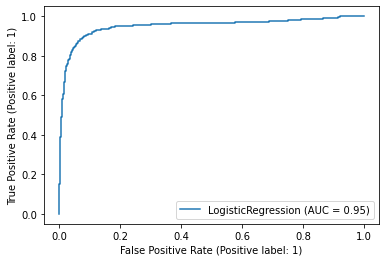

In [109]:
#### Plotting the roc curve for the model fit ####

plot_roc_curve(LR_model,X =features_train, y= target_train)

In [74]:
target_train.value_counts()

0    7255
1     869
Name: Revenue Grid, dtype: int64

In [75]:
### Getting confusion matrix, F-score on the train data #####

print(confusion_matrix(y_true = target_train, y_pred = LR_model.predict(features_train))) 
### confusion matrix for pred on train set

print ('The F1-SCORE on the train set prediction ',f1_score(y_true=target_train, y_pred = LR_model.predict(features_train)))

[[7172   83]
 [ 350  519]]
The F1-SCORE on the train set prediction  0.7056424201223658


In [76]:
##### Lets evaluate the performace on the test set #####
#print(Y_val.value_counts())

#plot_roc_curve(LR_model,X =features_val, y= target_val)

predicted_val = LR_model.predict(features_val)

print (confusion_matrix(y_true = target_val, y_pred = predicted_val))

print ('The F1-SCORE on the test set prediction ',f1_score(y_true=target_val,y_pred = predicted_val))

[[1783   31]
 [  78  139]]
The F1-SCORE on the test set prediction  0.7183462532299741


In [77]:
###### Save a model ######
with open('NamsLR.pickle','wb') as f:
  pickle.dump(LR_model,f)

In [78]:
####### Load a model back #####
with open('NamsLR.pickle','rb') as f:
  model = pickle.load(f)

In [79]:
##### fitting a decision tree #####


clf = DecisionTreeClassifier(class_weight = {0:0.45, 1:0.55},
                             max_depth = 6, 
                             criterion = 'gini',
                             min_samples_split=25)

clf.fit(features_train,target_train)

DecisionTreeClassifier(class_weight={0: 0.45, 1: 0.55}, max_depth=6,
                       min_samples_split=25)

In [80]:
clf.predict(features_train) ### .predict method helps you to predict

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [81]:
features_train.columns

Index(['Average Credit Card Transaction', 'Balance Transfer', 'Term Deposit',
       'Life Insurance', 'Medical Insurance', 'Average A/C Balance',
       'Personal Loan', 'Investment in Mutual Fund',
       'Investment Tax Saving Bond', 'Home Loan', 'Online Purchase Amount',
       'Investment in Commudity', 'Investment in Equity',
       'Investment in Derivative', 'Portfolio Balance', 'chidren_1',
       'chidren_2', 'chidren_3', 'chidren_4+', 'chidren_Zero',
       'age_band_18-21', 'age_band_22-25', 'age_band_26-30', 'age_band_31-35',
       'age_band_36-40', 'age_band_41-45', 'age_band_45-50', 'age_band_51-55',
       'age_band_55-60', 'age_band_61-65', 'age_band_65-70', 'age_band_71+',
       'age_band_Unknown', 'status_Divorced/Separated', 'status_Partner',
       'status_Single/Never Married', 'status_Unknown', 'status_Widowed',
       'occupation_Housewife', 'occupation_Manual Worker', 'occupation_Other',
       'occupation_Professional', 'occupation_Retired',
       'occupati

In [82]:
clf.predict(features_val)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [83]:
clf.classes_ ### give us the classes that were present on the training set and that were used by the model to train on

dict(zip(list(features_train.columns),list(clf.feature_importances_)))

{'Average Credit Card Transaction': 0.11143015993480801,
 'Balance Transfer': 0.0,
 'Term Deposit': 0.06651062435570163,
 'Life Insurance': 0.07577077707961452,
 'Medical Insurance': 0.010300086252838793,
 'Average A/C Balance': 0.005588671406739026,
 'Personal Loan': 0.05089157240400086,
 'Investment in Mutual Fund': 0.006109922956560151,
 'Investment Tax Saving Bond': 0.10630533330949231,
 'Home Loan': 0.010167845258025533,
 'Online Purchase Amount': 0.48722473426974483,
 'Investment in Commudity': 0.007211058457810284,
 'Investment in Equity': 0.05507351732284421,
 'Investment in Derivative': 0.004356329385757154,
 'Portfolio Balance': 0.0,
 'chidren_1': 0.0,
 'chidren_2': 0.0,
 'chidren_3': 0.0,
 'chidren_4+': 0.0,
 'chidren_Zero': 0.0,
 'age_band_18-21': 0.0,
 'age_band_22-25': 0.0,
 'age_band_26-30': 0.0,
 'age_band_31-35': 0.0,
 'age_band_36-40': 0.0,
 'age_band_41-45': 0.0,
 'age_band_45-50': 0.0,
 'age_band_51-55': 0.0,
 'age_band_55-60': 0.0,
 'age_band_61-65': 0.0,
 'age_ban

In [84]:
features_train.columns

Index(['Average Credit Card Transaction', 'Balance Transfer', 'Term Deposit',
       'Life Insurance', 'Medical Insurance', 'Average A/C Balance',
       'Personal Loan', 'Investment in Mutual Fund',
       'Investment Tax Saving Bond', 'Home Loan', 'Online Purchase Amount',
       'Investment in Commudity', 'Investment in Equity',
       'Investment in Derivative', 'Portfolio Balance', 'chidren_1',
       'chidren_2', 'chidren_3', 'chidren_4+', 'chidren_Zero',
       'age_band_18-21', 'age_band_22-25', 'age_band_26-30', 'age_band_31-35',
       'age_band_36-40', 'age_band_41-45', 'age_band_45-50', 'age_band_51-55',
       'age_band_55-60', 'age_band_61-65', 'age_band_65-70', 'age_band_71+',
       'age_band_Unknown', 'status_Divorced/Separated', 'status_Partner',
       'status_Single/Never Married', 'status_Unknown', 'status_Widowed',
       'occupation_Housewife', 'occupation_Manual Worker', 'occupation_Other',
       'occupation_Professional', 'occupation_Retired',
       'occupati

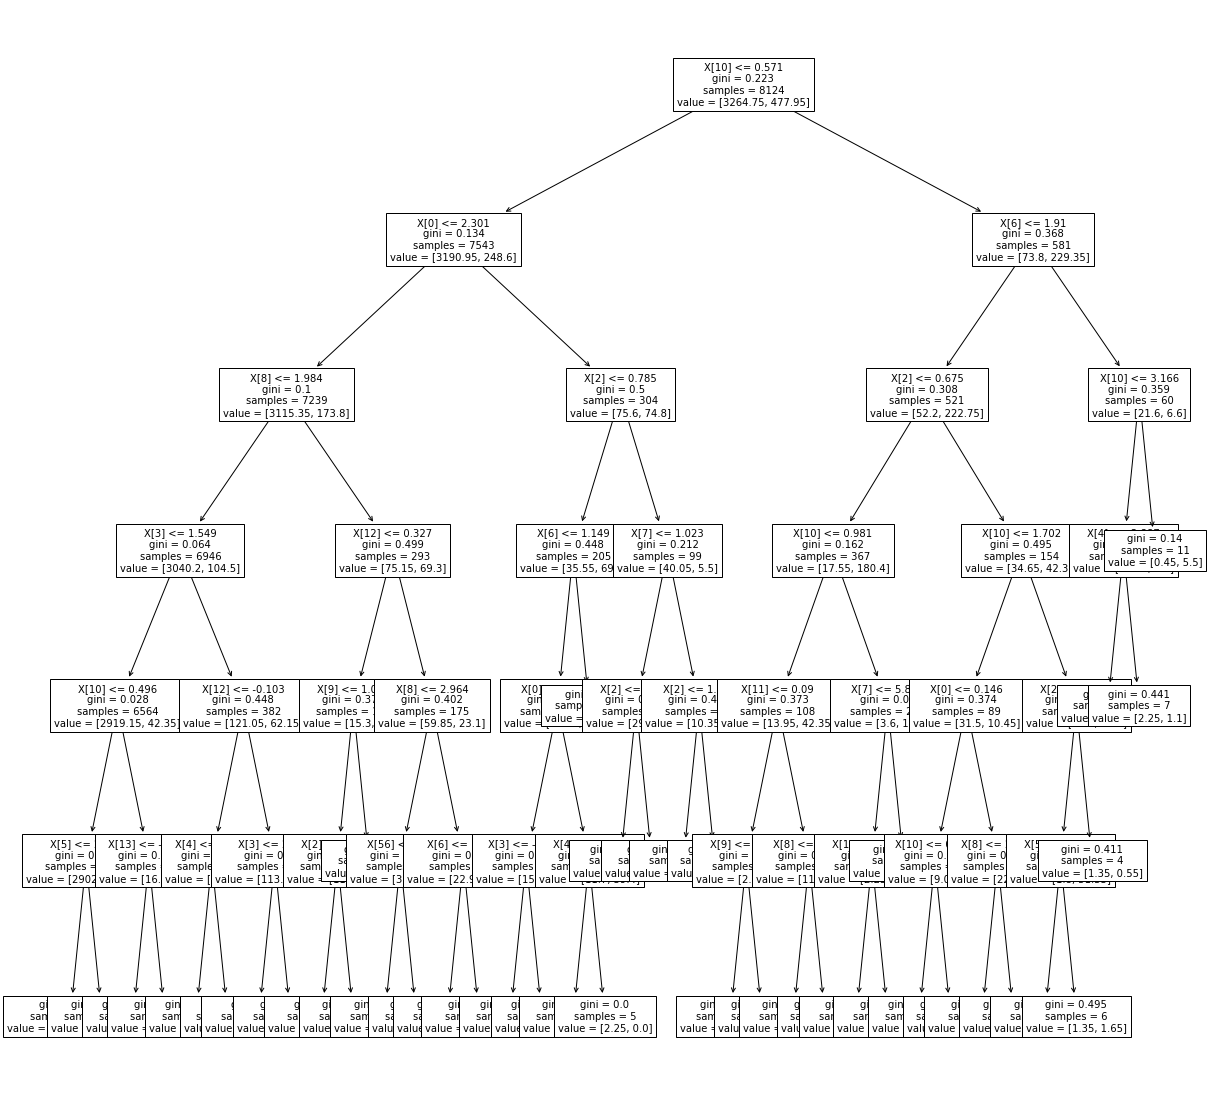

In [85]:
from sklearn.tree import plot_tree
plot_rows =1
plot_cols = 1

fig, ax1 = plt.subplots(nrows = plot_rows,ncols=plot_cols,figsize = (20,20))

plot_tree(clf,ax=ax1,fontsize=10)
plt.show()

[[7141  114]
 [ 170  699]]
The F1-SCORE on the train set prediction  0.83115338882283


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


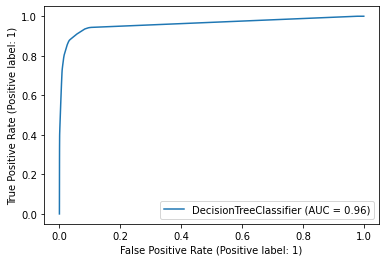

In [86]:
### Evaluating on the train and the test set ####

predicted_train = clf.predict(features_train)

plot_roc_curve(clf,X =features_train, y= target_train)

#print ('The score for the DT model ', roc_auc_score(Y_train,predicted_train))

print(confusion_matrix(y_true = target_train, y_pred = predicted_train))

print ('The F1-SCORE on the train set prediction ',f1_score(y_true=target_train,y_pred = predicted_train))

[[1767   47]
 [  38  179]]
The F1-SCORE on the val set prediction  0.8081264108352144


C:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


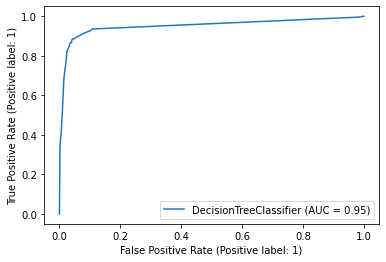

In [87]:
plot_roc_curve(clf,X =features_val, y= target_val)

predicted_test = clf.predict(features_val)

print (confusion_matrix(y_true = target_val, y_pred = predicted_test))

print ('The F1-SCORE on the val set prediction ',f1_score(y_true=target_val,y_pred = predicted_test))

In [90]:
##### Creating a decision tree classifier ####

clf = DecisionTreeClassifier()
#clf = LogisticRegression()  
#clf = SVC()

params={'class_weight':[None,'balanced', {0:0.4,1:0.6}, {0:0.45, 1:0.55}, {0:0.55, 1:0.45}, {0:0.6, 1:0.4}],
        'max_depth' : [5, 8, 10, 15, 20],
        'criterion' :['gini'],
        'min_samples_split' : [2,5,10,20],
        'max_features': [None, 'sqrt', 0.5, 0.6, 0.7, 0.8, 0.9]
        } 

grid_search = GridSearchCV(estimator = clf, param_grid = params, cv = 5, scoring = 'f1', return_train_score=True) #### cv- 5 (5 fold cross validation)

grid_search.fit(features_df, target_df)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [None, 'balanced', {0: 0.4, 1: 0.6},
                                          {0: 0.45, 1: 0.55},
                                          {0: 0.55, 1: 0.45},
                                          {0: 0.6, 1: 0.4}],
                         'criterion': ['gini'], 'max_depth': [5, 8, 10, 15, 20],
                         'max_features': [None, 'sqrt', 0.5, 0.6, 0.7, 0.8,
                                          0.9],
                         'min_samples_split': [2, 5, 10, 20]},
             return_train_score=True, scoring='f1')

In [91]:
6*5*1*4*7

840

In [92]:
list(grid_search.cv_results_.keys())

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_class_weight',
 'param_criterion',
 'param_max_depth',
 'param_max_features',
 'param_min_samples_split',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score',
 'split0_train_score',
 'split1_train_score',
 'split2_train_score',
 'split3_train_score',
 'split4_train_score',
 'mean_train_score',
 'std_train_score']

In [ ]:
len(grid_search.cv_results_['rank_test_score'])

840

In [ ]:
grid_search.cv_results_['params'][478]

{'class_weight': {0: 0.45, 1: 0.55},
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': None,
 'min_samples_split': 10}

In [ ]:
grid_search.cv_results_['mean_test_score'][478]

0.790739326563467

In [ ]:
grid_search.cv_results_['mean_train_score'][478]

0.9343070958623014

In [ ]:
grid_search.cv_results_['rank_test_score']

array([415, 412, 420, 411, 823, 836, 805, 837, 660, 610, 701, 692, 650,
       621, 709, 691, 613, 638, 671, 653, 484, 631, 502, 556, 543, 620,
       433, 617, 112,  46,  65,  66, 808, 816, 812, 794, 155, 463, 479,
       151,  60, 170, 122, 251,  93, 111, 147, 339, 126,  45,  21,  44,
        75,  20, 110,  81,  74, 178, 159,  59, 737, 743, 756, 777, 473,
       212, 355, 288, 103, 275,  98, 222, 199, 395, 451, 391, 269, 436,
       261, 185,  54,  23,  29, 274, 301, 350, 308, 157, 725, 772, 771,
       749, 418, 521, 399, 361, 419, 336, 209, 356, 430, 443, 332, 455,
       311, 346, 129, 202, 265,  99, 255,  84, 377, 328, 345, 136, 733,
       744, 720, 746, 531, 522, 298, 422, 453, 509, 315, 454, 390, 516,
       340, 241, 394, 373,  58, 191, 352, 330, 182, 216, 686, 679, 681,
       687, 827, 833, 825, 835, 713, 717, 719, 706, 700, 715, 699, 712,
       677, 721, 718, 689, 702, 698, 708, 694, 690, 673, 705, 696, 519,
       524, 540, 541, 802, 824, 817, 807, 586, 655, 710, 651, 61

In [93]:
list(grid_search.cv_results_['rank_test_score']).index(1)

478

In [94]:
df = pd.DataFrame(zip(grid_search.cv_results_['params'], 
                      grid_search.cv_results_['mean_train_score'], 
                      grid_search.cv_results_['mean_test_score']), columns = ['param_comb', 'Train_F1', 'Val_F1'])

df.to_excel('grid_search_results.xlsx', index=None)

In [98]:
clf = DecisionTreeClassifier(class_weight= None, criterion = 'entropy', max_depth = 7, min_samples_split = 10)

clf.fit(features_train,target_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=10)

In [99]:
###### Storing the model ######
with open('best_model.pickle', 'wb') as f:
  pickle.dump(clf,f)

In [100]:
####### Load the existing model ######
with open ('best_model.pickle', 'rb') as f:
  model = pickle.load(f)

In [105]:
model.predict(features_val)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [106]:
#### Saving the model ###

with open('decision_tree_model.pickle','wb') as f:
    pickle.dump(clf,f)


In [107]:
########## Concluded that Decision Tree Algo is best Model ##############